In [120]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import joblib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [148]:
df = pd.read_csv('data/AB_NYC_2019.csv')

In [149]:
df.shape

(48895, 16)

In [150]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [151]:
for i in range(len(df.columns)):
    print(f'{df.dtypes.index[i]} ====>>>> {df.dtypes[i]} type')

id ====>>>> int64 type
name ====>>>> object type
host_id ====>>>> int64 type
host_name ====>>>> object type
neighbourhood_group ====>>>> object type
neighbourhood ====>>>> object type
latitude ====>>>> float64 type
longitude ====>>>> float64 type
room_type ====>>>> object type
price ====>>>> int64 type
minimum_nights ====>>>> int64 type
number_of_reviews ====>>>> int64 type
last_review ====>>>> object type
reviews_per_month ====>>>> float64 type
calculated_host_listings_count ====>>>> int64 type
availability_365 ====>>>> int64 type


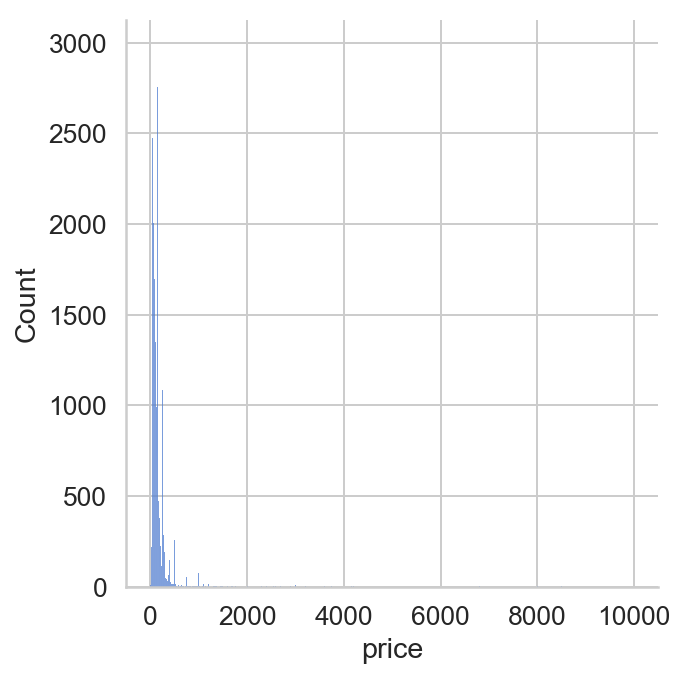

In [152]:
# How is the price distribution of airbnb listings
sns.displot(df.price)

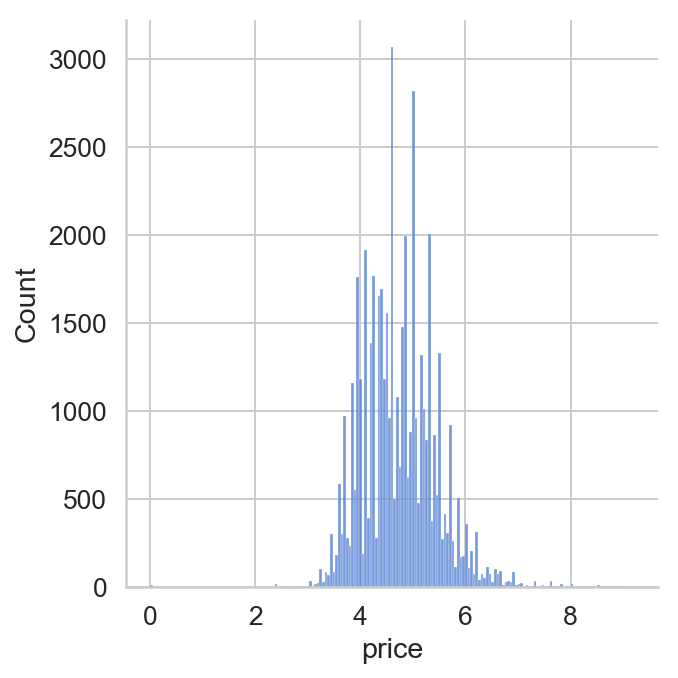

In [153]:
# distribution looked highly skewed
# let's take log transform for better visual
sns.displot(np.log1p(df.price))

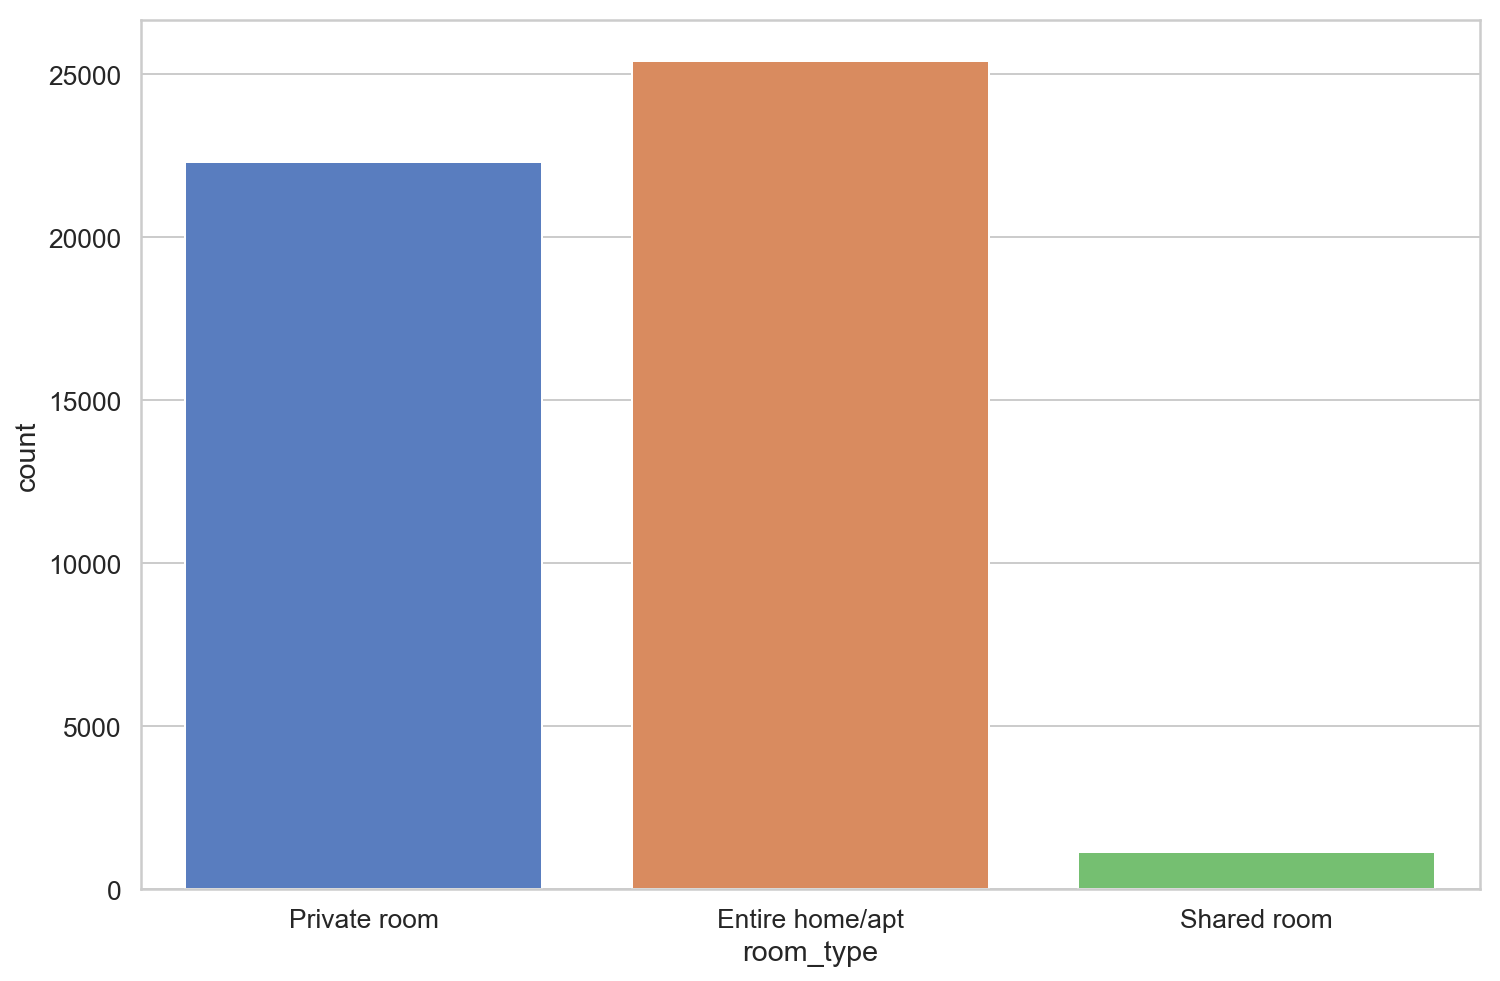

In [154]:
# let's check count of room types in all the listings
sns.countplot(x='room_type', data=df)

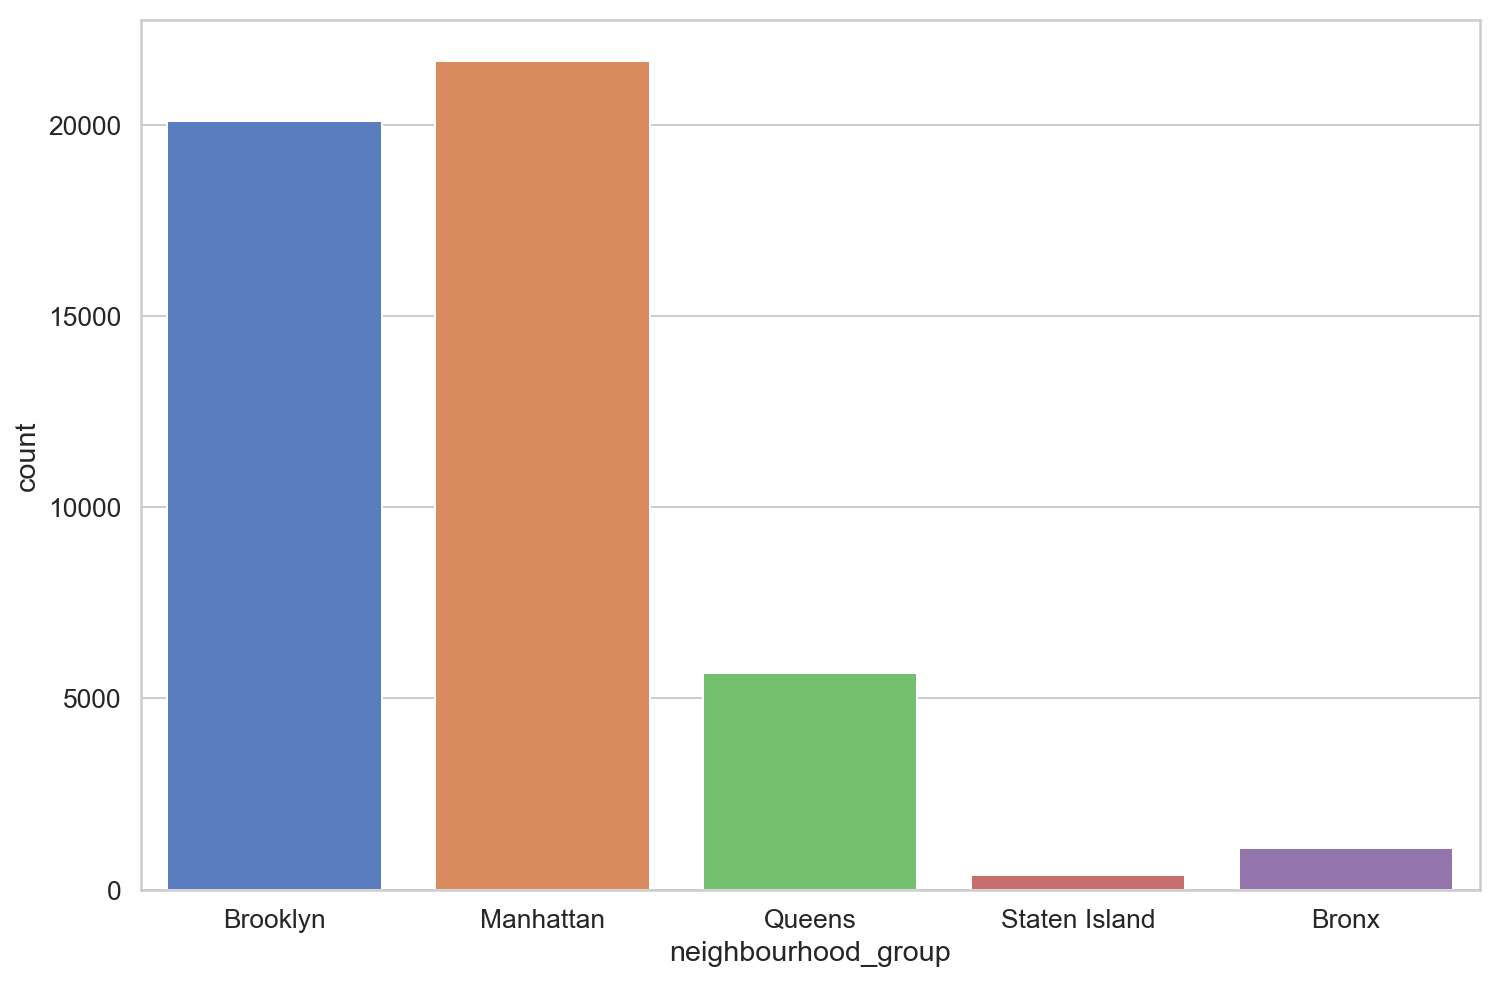

In [155]:
# Let's check the neighbourhood
sns.countplot(x='neighbourhood_group', data=df)

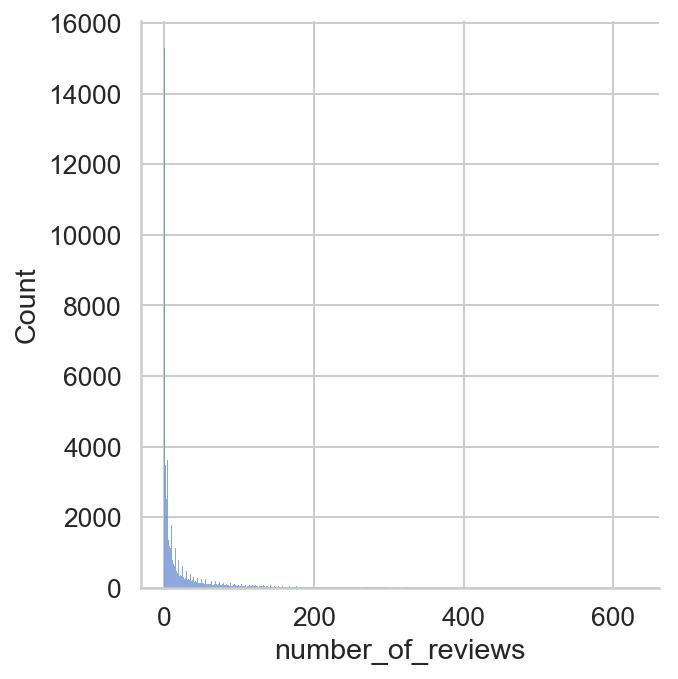

In [156]:
# Let's check home many review each listing gets
sns.displot(df.number_of_reviews)

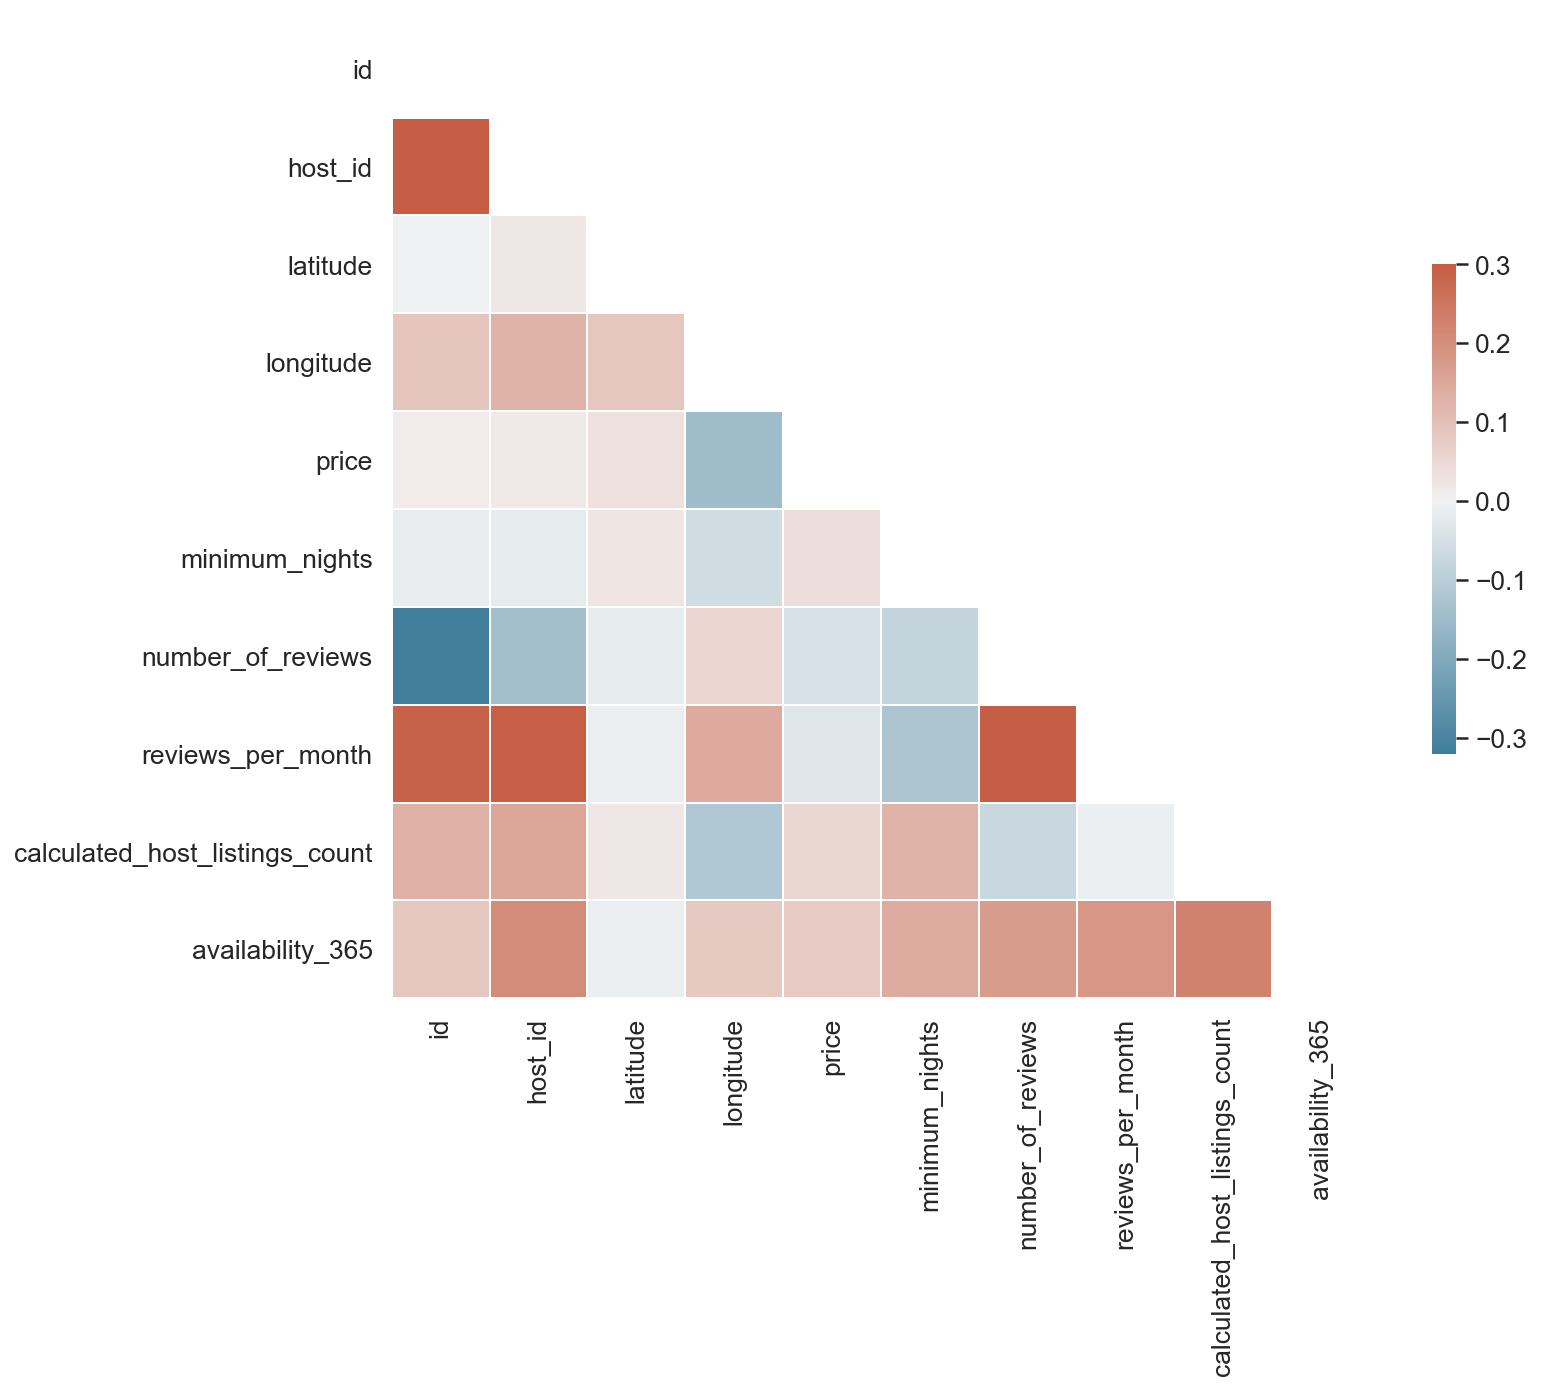

In [157]:
# Let's check correlation between variables
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [158]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

In [159]:
# Handling missing data
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64

In [160]:
df = df.drop(['id', 'name', 'host_id', 'host_name','reviews_per_month', 'last_review', 'neighbourhood'], axis=1)

In [161]:
#df.reviews_per_month.fillna(df.reviews_per_month.mean(), inplace=True)

In [162]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)

In [163]:
# Let's do feature scaling before modelling
transformer = make_column_transformer(
    (MinMaxScaler(), [
        'latitude', 'longitude', 'minimum_nights',
        'number_of_reviews', 'calculated_host_listings_count',
        'availability_365'
    ]),
    (OneHotEncoder(handle_unknown='ignore', sparse=False),[
        'neighbourhood_group', 'room_type'
    ])
)

transformer.fit(X)
X = transformer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=RANDOM_SEED)

In [164]:
# DNN model with keras
model = keras.Sequential()
model.add(keras.layers.Dense(units=64,activation='relu',input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss='mae',
    metrics=['mae']
)

BATCH_SIZE=32

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mae',
    mode = 'min',
    patience=10
)

history = model.fit(
    x=X_train,
    y=y_train,
    shuffle=True,
    epochs=10,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
978/978 [==============================] - 2s 2ms/step - loss: 3.2464 - mae: 3.2464 - val_loss: 0.4716 - val_mae: 0.4716
Epoch 2/10
978/978 [==============================] - 1s 1ms/step - loss: 1.1094 - mae: 1.1094 - val_loss: 0.4549 - val_mae: 0.4549
Epoch 3/10
978/978 [==============================] - 2s 2ms/step - loss: 1.0627 - mae: 1.0627 - val_loss: 0.4265 - val_mae: 0.4265
Epoch 4/10
978/978 [==============================] - 3s 3ms/step - loss: 1.0225 - mae: 1.0225 - val_loss: 0.4357 - val_mae: 0.4357
Epoch 5/10
978/978 [==============================] - 2s 2ms/step - loss: 1.0073 - mae: 1.0073 - val_loss: 0.4513 - val_mae: 0.4513
Epoch 6/10
978/978 [==============================] - 2s 2ms/step - loss: 0.9774 - mae: 0.9774 - val_loss: 0.4287 - val_mae: 0.4287
Epoch 7/10
978/978 [==============================] - 2s 2ms/step - loss: 0.9523 - mae: 0.9523 - val_loss: 0.4312 - val_mae: 0.4312
Epoch 8/10
978/978 [==============================] - 2s 2ms/step - loss: 0.

In [165]:
y_pred = model.predict(X_test)

print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')

MSE 0.30137993423772136
RMSE 0.5489808140889091


In [166]:
print(f'R2 {r2_score(y_test, y_pred)}')

R2 0.3629512072195825


In [167]:
joblib.dump(transformer, 'assets/data_transformer.joblib')
model.save('assets/price_prediction_model.h5')